# <center> Финальный проект. Идентификация пользователей по посещенным веб-страницам<enter>

В этом проекте целью будет научиться работать с признаками, выбирать алгоритмы и настраивать гиперпараметры. Основная задача же проекта: Идентификация пользователя по его поведению в сети интернет. 

По данным содержащим последовательности из нескольких веб-сайтов, посещенных подряд один и тем же человеком, а так же временные метки начала каждой сессии, мы будем пытаться идентифицировать этого человека.
    
Задача является актуальной и многие интернет сервисы пытаются ее решать.
    
Для структурирования всей работы предлагаю следующий план работы:
    - Анализ представленных данных
    - Первые попытки выбора и валидации моделей
    - Создание дополнительных признаков
    - Оценка полученных результатов

Если на первых шагах мы будем работать с игрушечными данными (3 и 10 пользователей), то в последующем для работы с большим количеством пользователей (150 и 400) мы напишем свой pipeline для автоматизации промежуточных преобразований.
    
Итак, приступим..
    

## 1. Анализ представленных данных

**Посмотрим на один из файлов с данными о посещенных пользователем веб-страницах.**

In [1]:
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
import pickle
from tqdm import tqdm_notebook 
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.sparse import csr_matrix

In [2]:
PATH_TO_DATA = './capstone_user_identification/'

In [3]:
user31_data = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                       '10users/user0031.csv'))

In [4]:
user31_data.head()

,timestamp,site
0,2013-11-15 08:12:07,fpdownload2.macromedia.com
1,2013-11-15 08:12:17,laposte.net
2,2013-11-15 08:12:17,www.laposte.net
3,2013-11-15 08:12:17,www.google.com
4,2013-11-15 08:12:18,www.laposte.net


Каждый файл с логами пользователя содержит временную метку захода на сайт и имя сайта. 

С подобными сырыми данными работать сложно, для дальнейшего анализа потребуется переформатировать данные в единый датасет. Так же стоит рассмотреть возможности добавления новых признаков, которые могут улучшить работу модели в будущем.

Объединим данные по пользователям и сгруппируем их в сессии по 10 сайтов. Этот параметр не является догмой и взят для удобства. При желании и наличии достаточных вычислительных мощностей можно взять разные длины сессий (7, 10, 15 ...) и сравнить результаты. 

Доменные имена сайтов заменим ИД для удобства

Так же при группировке добавим несколько новых признаков: - длительность пребывания на сайте, -общая продолжительность сессии, - количество уникальных сайтов в сессии, -час начала сессии, - день недели начала сессии.

Пока для тестирования функции и визуального изучения данных будем использовать данные 3-х и 10-и пользователей, а уже для выбора модели и ее гиперпараметров в последующем напишем небольшой pipeline.

In [5]:
def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names,
                                    session_length=10, window_size=10):
    list_of_files = os.listdir(path=path_to_csv_files)
    # чтение файла с частотами
    with open(site_freq_path, 'rb') as f:
        site_freqs = pickle.load(f)
        
    target = []
    row = []
    col = []
    data1 = []
    ind_row = 0
    # обход файлов
    for file in tqdm_notebook(list_of_files):
        if os.path.isfile(os.path.join(path_to_csv_files, file)):
            if file.startswith('user'):
                # получение id пользователя 
                user_id = int(file[4:-4])                
                
                # сбор данных по сессиям пользователя
                # на больших наборах необходимо заменить на прямое извлечение признаков из файлов
                data = pd.read_csv(os.path.join(path_to_csv_files, file), parse_dates=['timestamp'], dayfirst= True)
                # - получаем последовательность сайтов в сессии пользоавтеля
                data['site'] = data['site'].apply(lambda x: site_freqs[x][0]).values
                
                
                # получение отрезков из сессии
                start = 0
                session_len = session_length
                for i in range(int(np.ceil(len(data['site'])/window_size))):
                    session_slice = data.iloc[start: session_len]
                    # значения новых признаков
                    session_sites = session_slice['site']
                    
                    session_time_difs = [(session_slice.iloc[i+1].timestamp - session_slice.iloc[i].timestamp).seconds for i in range(session_slice.shape[0]-1)]
        
                    ses_timespan = (session_slice.iloc[-1].timestamp - session_slice.iloc[0].timestamp).seconds
            
                    ses_uniq_num = len(np.unique(session_slice['site']))
            
                    ses_start_hour = session_slice.iloc[0].timestamp.hour
                
                    ses_day_of_week = session_slice.iloc[0].timestamp.dayofweek
            
                    # заполнение данных по сессии
                    row += (len(session_sites) +  
                            len(session_time_difs) + 
                            5)* [ind_row] 
                    col += (list(range(len(session_sites))) + 
                            list(range(session_length, session_length + len(session_time_difs)))+
                           list(range(2*session_length - 1, 2*session_length + 4 )))
                    data1 += (list(session_sites) + 
                              session_time_difs + 
                              [ses_timespan] + 
                              [ses_uniq_num] + 
                              [ses_start_hour] +
                              [ses_day_of_week] + 
                              [user_id]
                             )
                    

                    # счетчики
                    ind_row += 1
                    start += window_size
                    session_len += window_size
                    
    return pd.DataFrame(csr_matrix((data1,(row,col))).todense(), columns=feature_names)

Проверим функцию на 10 пользователях, а затем, если нас все устроит, загрузим данные 150 пользователей и оценим распределения исходников

In [6]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']
train_data_10users  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '10users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_10users.pkl'),
                  feature_names=feature_names, session_length=10)

In [7]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,100,67,10,4,10,10,4,10,78,10,10,0,0,1,20,1,0,1,0,33,5,8,4,31
1,68,63,133,282,10,25,40,694,32,1,1,0,163,105,0,1,3,3,8,284,10,8,4,31
2,1,4,1,1,8,86,68,98,228,1,0,14,1,242,0,0,1,0,0,258,7,8,4,31
3,104,915,104,1,1,1,1,411,18,9,2,1,0,1,25,1,0,0,0,30,6,8,4,31
4,103,1,8,550,33,30,644,309,108,309,1,0,1,1,1,0,1,1,0,6,9,8,4,31


Отлично, у нас есть матерал для первичного просмотра данных и анализа распределений.

Для лучшего отображения графиков назначим каждому пользователю свой цвет.

In [8]:
train_data_10users.target.unique() # уникальные значения id пользователей в нашем датасете

array([ 31,  33,  39,  50, 100, 127, 128, 207, 237, 241], dtype=int32)

In [9]:
color_dic = {128: 'pink', 39: 'darkviolet', 207:'blueviolet', 
             127: 'hotpink', 237: 'orchid', 
             33: 'firebrick', 50: 'gold', 31: 'forestgreen', 
             100: 'slategrey', 241:'brown'}

Построим гистограмму распределения длины сессии в секундах

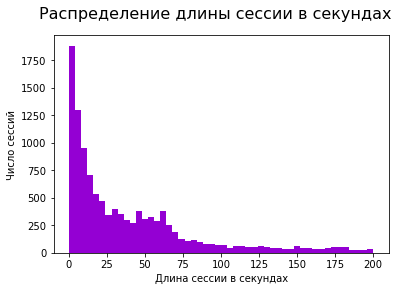

In [10]:
fig, ax = plt.subplots()
fig.suptitle(u'Распределение длины сессии в секундах',size=16)
ax.set_xlabel(u'Длина сессии в секундах')
ax.set_ylabel(u'Число сессий')
ax.hist(train_data_10users['session_timespan'][train_data_10users['session_timespan'] <= 200]  , bins=50, color='darkviolet')
plt.show();

Построим гистограмму распределения числа уникальных сайтов в сессии

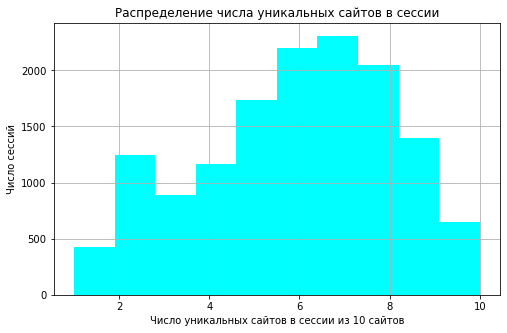

In [11]:
ses_unic = train_data_10users['#unique_sites'].hist(figsize=(8,5),
                                                   color='aqua')
ses_unic.set(xlabel='Число уникальных сайтов в сессии из 10 сайтов', ylabel='Число сессий', title='Распределение числа уникальных сайтов в сессии');

Построим гистограммы распределения числа уникальных сайтов в сессии (#unique_sites) для каждого из 10 пользователей по отдельности

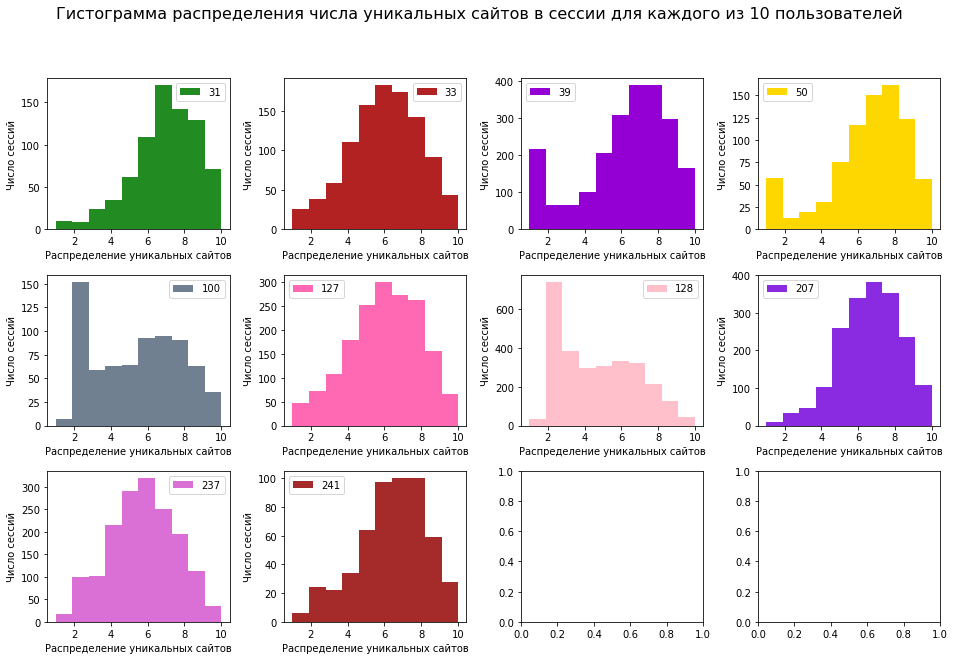

In [12]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
fig.suptitle(u'Гистограмма распределения числа уникальных сайтов в сессии для каждого из 10 пользователей',size=16);
fig.subplots_adjust(hspace = 0.3, wspace=0.3);
for idx, (user, sub_df) in  enumerate(train_data_10users.groupby(['target'])): 
    axes[idx//4][idx%4].hist(sub_df['#unique_sites'], 
                             color=color_dic[user])
    axes[idx//4][idx%4].set(xlabel='Распределение уникальных сайтов',
                           ylabel='Число сессий')
    axes[idx//4][idx%4].legend([user])

Построим гистограмму распределения часа начала сессии (start_hour)

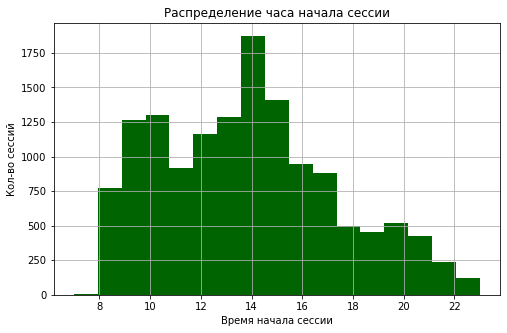

In [13]:
st_hour = train_data_10users['start_hour'].hist(figsize=(8,5),color='darkgreen', bins=17)
st_hour.set(xlabel='Время начала сессии', 
            ylabel='Кол-во сессий', 
            title='Распределение часа начала сессии');

Построим гистограммы распределения часа начала сессии (start_hour) для каждого из 10 пользователей по отдельности.

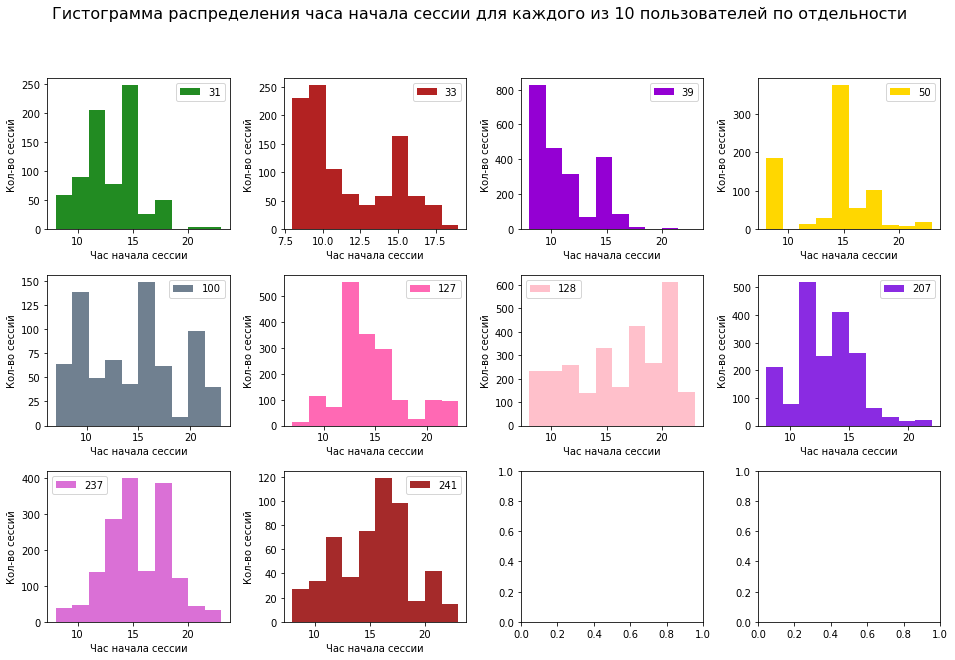

In [14]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
fig.suptitle(u'Гистограмма распределения часа начала сессии для каждого из 10 пользователей по отдельности',size=16)
fig.subplots_adjust(hspace = 0.3, wspace=0.3);
for idx, (user, sub_df) in  enumerate(train_data_10users.groupby(['target'])): 
    axes[idx//4][idx%4].hist(sub_df['start_hour'], 
                             color=color_dic[user])
    axes[idx//4][idx%4].set(xlabel='Час начала сессии',
                           ylabel='Кол-во сессий')
    axes[idx//4][idx%4].legend([user])

Построим гистограмму распределения дня недели

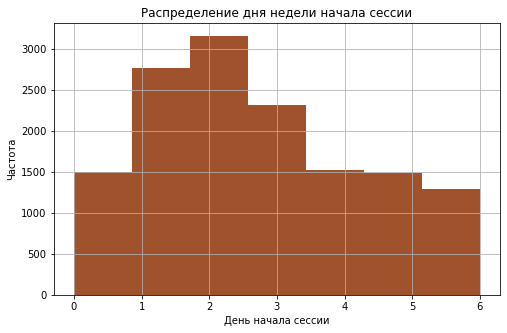

In [15]:
ses_day = train_data_10users['day_of_week'].hist(figsize=(8,5), color='sienna', bins=7)
ses_day.set(xlabel='День начала сессии', 
            ylabel='Частота', 
            title='Распределение дня недели начала сессии');

Построим гистограммы распределения дня недели, в который началась сессия (day_of_week) для каждого из 10 пользователей по отдельности

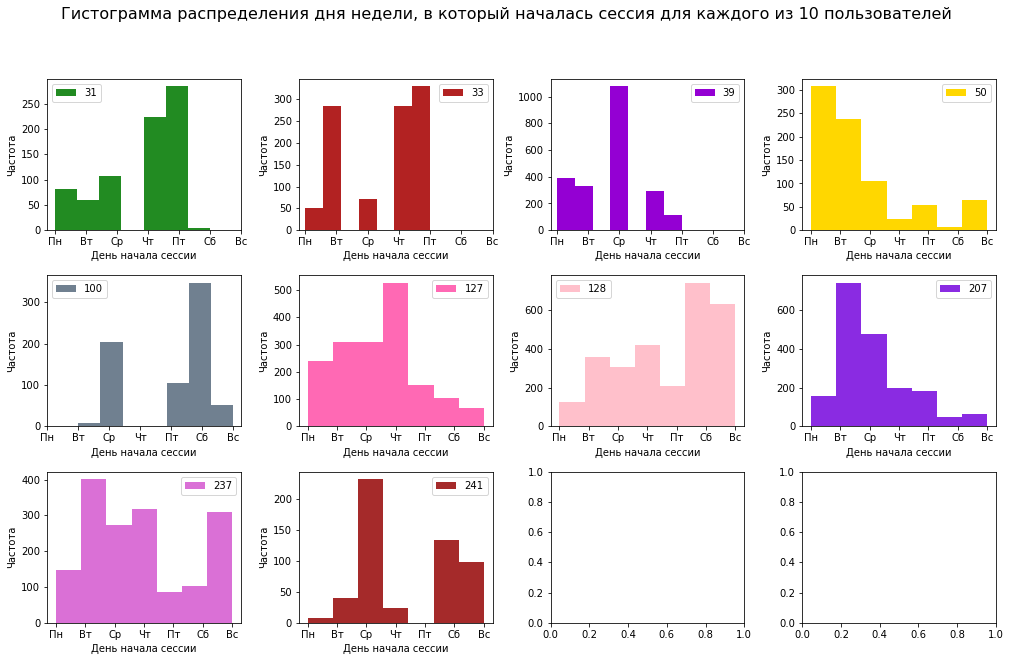

In [16]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(17, 10))
fig.suptitle(u'Гистограмма распределения дня недели, в который началась сессия для каждого из 10 пользователей',size=16)
fig.subplots_adjust(hspace = 0.3, wspace=0.3);
dates = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']
# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(train_data_10users.groupby(['target'])): 
    axes[idx//4][idx%4].hist(sub_df['day_of_week'], 
                             color=color_dic[user],
                            bins=7)
    axes[idx//4][idx%4].set(xlabel='День начала сессии',
                           ylabel='Частота')
    axes[idx//4][idx%4].legend([user])
    axes[idx//4][idx%4].set_xticks(range(7))
    axes[idx//4][idx%4].set_xticklabels(dates)

Даже первичный визуальный анализ признаков позволяет с уверенностью сказать, что пользователи ведут себя в сети по-разному. У всех свои привычки по времени начала работы, по разнообразию посещяемых сайтов, а некоторые пользователии работают вообще только по рабочим дням. Все это позволяет предположить, что модели классификации смогут различать пользователей и уверенно их классифицировать. 

В следующих разделах мы проверим эту теорию на нескольких разных алгоритмах.

## 2. Выбор базовой модели

Перед тем как приступать к выбору алгоритма необходимо еще немного доработать наши данные. Дело в том, что датасет содержащий ИД сайтов не сильно информативен для модели. В подобных случаях применяют подход называемый "Мешок слов". 

Для выбора модели мы используем самый "наивный" вариант Мешка слов, где будут выбраны все ИД (токены) сайтов, посчитаны вхожения  в каждой сессии, но при этом учитывать порядок их вхождения пока не будем.

Так как кол-во сайтов в сессии неизмеримо мало по сравнению с общим количеством сайтов, то полученная матрица будет очень сильно разреженная (sparse), т.е. почти все значения признаков в каждом объекте будут равняться нулю. Чтобы не хранить такое кол-во нулей и не забивать оперативную память будем использовать sparse-matrix формат, который хорошо воспринимается практически всеми алгоритмами.  

In [17]:
# отделим данные с индексами сайтов и приведем их к необходимому формату
sites = ['site%s' % i for i in range(1, 11)]
X = train_data_10users[sites].values.tolist()
text_raw_data = [" ".join([str(site) for site in row]) for row in X]
y = train_data_10users['target'].values

In [18]:
# загрузим необходимые библиотеки
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.model_selection import validation_curve
from sklearn.metrics import accuracy_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, SGDClassifier

CountVectorizer правильно применять только на тех данных, на которых в текущий момент обучается модель (чтоб не "подсматривать" в тестовую выборку и не считать по ней частоты вхождения слов).

Разобьем выборку на 2 части. На одной будем проводить кросс-валидацию, на второй – оценивать модель, обученную после кросс-валидации.

In [19]:
X_train_text, X_valid_text, y_train, y_valid = train_test_split(text_raw_data, y, 
                                                      test_size=0.3, 
                                                     random_state=17, stratify=y)

In [20]:
# создадим объект countvectorizer и обучим его только на тренировочных данных
cvt = CountVectorizer()
cvt.fit(X_train_text)

CountVectorizer()

In [21]:
# настройки для последующей стратификации
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

In [22]:
# Вспомогательная функция для отрисовки кривых валидации после запуска GridSearchCV (или RandomizedCV).
def plot_validation_curves(param_values, grid_cv_results_):
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()

In [23]:
# подготовим тренировочные и тестовые данные.
X_train = cvt.transform(X_train_text)
X_test = cvt.transform(X_valid_text)

Первой моделью попробуем KNeighborsClassifier

In [24]:
knn = KNeighborsClassifier(n_neighbors=100, n_jobs=-1)
knn_cvs = cross_val_score(knn, X_train, y_train, cv=skf).mean()
print(f'knn - cross_val_score: {knn_cvs}')

knn - cross_val_score: 0.4478775308935656


In [25]:
knn.fit(X_train, y_train)
knn_acc = accuracy_score(y_valid, knn.predict(X_test))
print(f'knn_accuracy score : {knn_acc}')

knn_accuracy score : 0.46029864896895


Как видим по результатам кросс-валидации KNeighborsClassifier плохо справляется с поставленными задачами. 

Второй моделью попробуем случайный лес (RandomForestClassifier) из 100 деревьев. Посмотрим на OOB-оценку  и на долю правильных ответов на выборке.

In [26]:
forest = RandomForestClassifier(n_estimators=100, random_state=17, oob_score=True, n_jobs=-1)
forest.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, oob_score=True, random_state=17)

In [27]:
forest_oob = forest.oob_score_
forest_acc = accuracy_score(y_valid, forest.predict(X_test))
print(f'oob:{forest_oob} ; acc:{forest_acc}')

oob:0.6970128022759602 ; acc:0.7044323299360038


Случайный лес справился заметно лучше

Теперь попробуем использовать линейные модели, а именно - логистическую регрессию

In [28]:
logit = LogisticRegression(random_state=17)
log_cvs = cross_val_score(logit, X_train, y_train, cv=skf).mean()
print(f'log_csv  = {log_cvs}')

log_csv  = 0.7453780450635961


In [29]:
logit.fit(X_train, y_train)
log_acc = accuracy_score(y_valid, logit.predict(X_test))
print(f'log_acc = {log_acc}')

log_acc = 0.7622659397961602


По полученным результатом видно, что линейные модели заметно лучше справляются с подобной задачей. Попробуем донастроить модель более тонко. Так как данных будет много, для ускорения вычислений необходимо использовать градиентный спуск, а так же попробуем внедрить в наш процесс небольшой pipeline, с помощью которого в последующем сможем быстро обрабатывать новые данные

In [30]:
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

Убедимся, что pipeline выдаст те же результаты, что мы получали в ручном режиме

In [31]:
pipe_logit = make_pipeline(CountVectorizer(), 
LogisticRegression(n_jobs=-1, random_state=7))

pipe_logit.fit(X_train_text, y_train)
print(pipe_logit.score(X_valid_text, y_valid))

0.7622659397961602


In [32]:
from sklearn.model_selection import GridSearchCV

In [33]:
param_grid_logit = {'logisticregression__C': np.linspace(0.1, 7, 20)}

grid_logit = GridSearchCV(pipe_logit, param_grid_logit, cv=skf, n_jobs=-1, return_train_score=True)

In [34]:
grid_logit.fit(X_train_text, y_train)
grid_logit.best_params_, grid_logit.best_score_

({'logisticregression__C': 1.1894736842105265}, 0.7452762641768448)

In [35]:
grid_logit.score(X_valid_text, y_valid)

0.7617918938136999

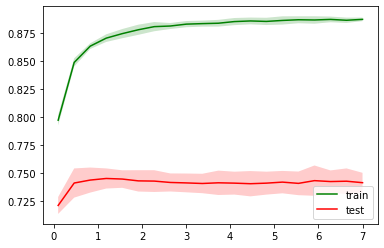

In [36]:
plot_validation_curves(param_grid_logit['logisticregression__C'], grid_logit.cv_results_)

На этом малом количестве данных мы попробовали разные базовые алгоритмы и выбрали базовую модель. Так же попробовали настраивать ее гиперпараметры для улучшения качества. Но на больших данных логарифмическая регрессия будет работать очень долго, поэтому в дальнейшем мы будем использовать стохастический градиентный спуск.

Так же можно заметить, что точность при многоклассовой классификации не удовлетварительная, а мы всего лишь искали среди 10 классов. Но, как покажут наши дальнейшие изыскания, подобный подход хорошо работает для поиска одного класса среди всех.

## 3. Создание дополнительных признаков

С этого момента мы будем использовать большую базу на 400 пользователей, а так же создадим дополнительные признаки, которые помогут улучшить качество модели.

Данные возьмем из соревнования на Kaggle, они уже в том формате, который мы готовили самостоятельно из логов.

В качестве инструмента будем использовать кастомный pipeline, который облегчит обработку данных и настройку модели.

In [37]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

In [38]:
train_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_sessions.csv'),
                       index_col='session_id')
test_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_sessions.csv'),
                      index_col='session_id')

In [39]:
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
1,718,2014-02-20 10:02:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,2014-02-22 11:19:51,3846.0,2014-02-22 11:19:51,3847.0,2014-02-22 11:19:52,3846.0,2014-02-22 11:19:52,1516.0,2014-02-22 11:20:15,1518.0,2014-02-22 11:20:16,0
3,14769,2013-12-16 16:40:17,39.0,2013-12-16 16:40:18,14768.0,2013-12-16 16:40:19,14769.0,2013-12-16 16:40:19,37.0,2013-12-16 16:40:19,39.0,2013-12-16 16:40:19,14768.0,2013-12-16 16:40:20,14768.0,2013-12-16 16:40:21,14768.0,2013-12-16 16:40:22,14768.0,2013-12-16 16:40:24,0
4,782,2014-03-28 10:52:12,782.0,2014-03-28 10:52:42,782.0,2014-03-28 10:53:12,782.0,2014-03-28 10:53:42,782.0,2014-03-28 10:54:12,782.0,2014-03-28 10:54:42,782.0,2014-03-28 10:55:12,782.0,2014-03-28 10:55:42,782.0,2014-03-28 10:56:12,782.0,2014-03-28 10:56:42,0
5,22,2014-02-28 10:53:05,177.0,2014-02-28 10:55:22,175.0,2014-02-28 10:55:22,178.0,2014-02-28 10:55:23,177.0,2014-02-28 10:55:23,178.0,2014-02-28 10:55:59,175.0,2014-02-28 10:55:59,177.0,2014-02-28 10:55:59,177.0,2014-02-28 10:57:06,178.0,2014-02-28 10:57:11,0


In [40]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 253561 entries, 1 to 253561
Data columns (total 21 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   site1   253561 non-null  int64  
 1   time1   253561 non-null  object 
 2   site2   250098 non-null  float64
 3   time2   250098 non-null  object 
 4   site3   246919 non-null  float64
 5   time3   246919 non-null  object 
 6   site4   244321 non-null  float64
 7   time4   244321 non-null  object 
 8   site5   241829 non-null  float64
 9   time5   241829 non-null  object 
 10  site6   239495 non-null  float64
 11  time6   239495 non-null  object 
 12  site7   237297 non-null  float64
 13  time7   237297 non-null  object 
 14  site8   235224 non-null  float64
 15  time8   235224 non-null  object 
 16  site9   233084 non-null  float64
 17  time9   233084 non-null  object 
 18  site10  231052 non-null  float64
 19  time10  231052 non-null  object 
 20  target  253561 non-null  int64  
dtypes: float64

Как видим, временные метки не распознались, нам требуется преобразовать их для дальнейшей работы

In [41]:
for i in range(1, 11):
    train_df['time{}'.format(i)] = pd.to_datetime(train_df['time{}'.format(i)])
for i in range(1, 11):
    test_df['time{}'.format(i)] = pd.to_datetime(test_df['time{}'.format(i)])

Будем описывать свой pipeline. Фактически, это просто класс, наследуемый от двух родительских и имеющий два обязательных метода: fit и transform

In [42]:
class DataPreparator(BaseEstimator, TransformerMixin):
    """
    Удаляем пустые поля, заменяем их нулями и приводим тип данных к int
    """
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        sites = ['site%s' % i for i in range(1, 11)]
        return X[sites].fillna(0).astype('int')

In [43]:
class ListPreparator(BaseEstimator, TransformerMixin):
    """
    Подготовим данные для CountVectorizer. Ранее мы делали это вручную
    """
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = X.values.tolist()
        # Конвертируем данные в строки и разделим пробелами
        return [" ".join([str(site) for site in row]) for row in X]

In [44]:
class RealAttributesAdder(BaseEstimator, TransformerMixin):
    """
    Добавим дополнительные вещественные признаки к нашим данным, которе впоследствии надо масштабировать.
    В данном случае добавим длину сессии.
    """
    def fit(self, X, y=None):
        return self 
    
    def transform(self, X, y=None):
        # получение всех столбцов с временными метками
        timestamps = [f'time{i}' for i in range(1, 11)]
        
        session_timespan = (X[timestamps].max(axis=1) - X[timestamps].min(axis=1)).astype('timedelta64[ms]').astype(int) ** 0.2
        
        X = session_timespan.values.reshape(-1, 1)
        
        return X

In [45]:
class AttributesAdder(BaseEstimator, TransformerMixin):
    """
    Добавим новые категориальные признаки
    """
    def fit(self, X, y=None):
        return self 
    def transform(self, X, y=None):
        # час начала сессии
        hour = X['time1'].apply(lambda ts: ts.hour)
        
        # в какое время дня начата сессия
        morning = ((hour >= 7) & (hour <= 11)).astype('int')
        day = ((hour >= 12) & (hour <= 18)).astype('int')
        evening = ((hour >= 19) & (hour <= 23)).astype('int')
        
        # время года
        month = X['time1'].apply(lambda ts: ts.month)
        summer = ((month >= 6) & (month <= 8)).astype('int')
        
        # день недели
        weekday = X['time1'].apply(lambda ts: ts.weekday()).astype('int')
        
        # год
        year = X['time1'].apply(lambda ts: ts.year).astype('int')
        
        X = np.c_[hour.values, morning.values, day.values, evening.values, summer.values, weekday.values, year.values]
        return X

Теперь нам потребуется объединить все созданные классы в необходимые нам цепочки. 

vectorizer_pipeline будет готовить данные для создания мешка слов с помощью CountVectorizer. Сейчас мы уже будем учитывать серии сайтов с помощью ngram. 

attributes_pipeline - добавим категориальные признаки и закодируем их.

scaled_attributes_pipeline - добавим вещественные признаки и масштабируем их.

In [46]:
vectorizer_pipeline = Pipeline([
    ("preparator", DataPreparator()),
    ("list_preparator", ListPreparator()),
    ("vectorizer", CountVectorizer(ngram_range=(1, 3), max_features=50000))
])

attributes_pipeline = Pipeline([
    ("cat_adder", AttributesAdder()),
    ("encoder", OneHotEncoder(drop='first', dtype=np.int))
])

scaled_attributes_pipeline = Pipeline([
    ("real_adder", RealAttributesAdder()),
    ("scaler", StandardScaler())
])

Можем объединить все полученные классы в один конвеер

In [47]:
full_pipeline = FeatureUnion(transformer_list=[
('vectorizer_pipeline', vectorizer_pipeline),
('attributes_pipeline', attributes_pipeline),
('scaled_attributes_pipeline', scaled_attributes_pipeline)
])

Мы получили хороший инструмент для упрощения работы с данными. Для введения коррекций необходимо просто исправить соответствующий класс, это позволит существенно ускорить подбор и настройку моделей.

In [48]:
X_train = full_pipeline.fit_transform(train_df)
X_test = full_pipeline.transform(test_df)

y_train = train_df["target"].astype('int').values

## 4. Оценка полученных результатов

Воспользуемся полученными данными и обучим подобранную ранее модель. 

Пока будем использовать параметры по-умолчанию, а результаты оценим на кросс-валидации

In [49]:
sgd_model = SGDClassifier(loss='log', random_state=17, n_jobs=-1)


cv_scores = cross_val_score(sgd_model, X_train, y_train, cv=skf, 
                        scoring='roc_auc', n_jobs=-1)

cv_scores.mean()

0.9773750666811751

Модель показывает высокие результаты, попробуем сделать submit, чтобы получить некий baseline, от которого можно будет отталкиваться далее при настройке модели

In [50]:
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [51]:
sgd_model.fit(X_train, y_train)
sgd_pred = sgd_model.predict_proba(X_test)

In [52]:
write_to_submission_file(sgd_pred[:, 1], 'sgd_model_pred.csv') # 0.94450 Yuriy Gr  rank 2257

Мы получили достаточно высокий baseline, теперь попробуем настроить модель. Для настройки будем подбирать гиперпараметр альфа

In [53]:
%%time
param_grid = {'alpha' : [0.000001, 0.0000015, 0.000002, 0.0000025, 0.000003, 0.0000035, 0.000004, \
                         0.000005, 0.0000075, 0.00001, 0.00005, 0.000075, 0.0001]}
sgd_grid = GridSearchCV(sgd_model, param_grid, scoring='roc_auc', cv=skf, n_jobs=-1,\
                        return_train_score=True, verbose=1)
sgd_grid.fit(X_train, y_train)

Fitting 3 folds for each of 13 candidates, totalling 39 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:   24.0s finished


Wall time: 25.6 s


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
             estimator=SGDClassifier(loss='log', n_jobs=-1, random_state=17),
             n_jobs=-1,
             param_grid={'alpha': [1e-06, 1.5e-06, 2e-06, 2.5e-06, 3e-06,
                                   3.5e-06, 4e-06, 5e-06, 7.5e-06, 1e-05, 5e-05,
                                   7.5e-05, 0.0001]},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [54]:
sgd_grid.best_params_, sgd_grid.best_estimator_

({'alpha': 1e-05},
 SGDClassifier(alpha=1e-05, loss='log', n_jobs=-1, random_state=17))

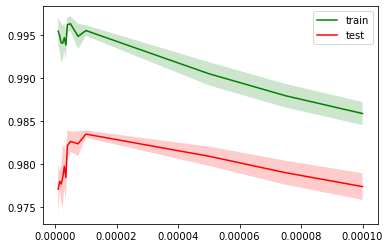

In [59]:
plot_validation_curves(param_grid['alpha'], sgd_grid.cv_results_)

In [55]:
sgd_final_model= sgd_grid.best_estimator_
sgd_final_model.fit(X_train, y_train)

SGDClassifier(alpha=1e-05, loss='log', n_jobs=-1, random_state=17)

In [56]:
sgd_final_pred = sgd_final_model.predict_proba(X_test)

In [57]:
write_to_submission_file(sgd_final_pred[:, 1], 'sgd_pred_final.csv') #  0.95158 Yuriy Gr rank 1309

Как видим, простой подбор только одного гиперпараметра улучшил точность почти на 1%.

Подведем наши скромные итоги.

В проделанной работе мы попробовали обрабатывать исходные данные, анализировать статистики, пробовали разные алгоритмы. Также построили свой pipeline, который позволяет отдельно обрабатывать вещественные и категориальные признаки, создавать новые просто изменяя соответствующие классы. После получения обучающей и тестовой выборки мы донастраивали выбранную ранее модель.
Результаты нашего участия в соревновании хоть и высокие, но говорят, что модель можно улучшать и дальше. Возможно, стоит попробовать Стекинг или Бустинг.

В чем может быть полезность данной модели для бизнеса? С помощью данной методики можно выявлять взломщиков веб-сервисов. Модель сможет с выской точностью определять, что действия производит не хозяин (манеру поведения которого она знает), блокировать сервис и просить подтверждения личности. 